In [1]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [2]:
# Load the dataset
file_path = "C:/Users/hp/OneDrive/Desktop/aapl_dataset.csv"  # Replace with your actual file
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
df = df.rename({'close_aapl': 'Close'}, axis=1)
df = df[['Close']]

In [3]:
# Step 1: Train-Test Split (BEFORE SCALING to avoid data leakage)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [4]:
# Step 2: Apply MinMaxScaler Separately on Train & Transform Test
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)  # Fit and transform on training data
test_scaled = scaler.transform(test)  # Transform only using training parameters

In [5]:
# Step 3: Convert Data into Sequences for LSTM
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [6]:
time_steps = 10  # Define how many previous days are used for prediction
X_train, y_train = create_sequences(train_scaled, time_steps)
X_test, y_test = create_sequences(test_scaled, time_steps)

In [7]:
# Reshape for LSTM (Samples, Timesteps, Features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [8]:
# Define time_steps before using it
time_steps = 10  # Adjust based on your dataset

# Define model building function
def build_lstm_model(hp):
    model = Sequential()
    
    # Tune LSTM units (50, 100, 150)
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=150, step=50),
                   return_sequences=True, input_shape=(time_steps, 1)))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=150, step=50),
                   return_sequences=False))
    
    # Dense layers
    model.add(Dense(units=hp.Int('dense_units', min_value=10, max_value=50, step=10), activation='relu'))
    model.add(Dense(1))
    
    # Tune Learning Rate
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    
    return model


In [9]:
# Set up the tuner
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,  # Try 10 different hyperparameter combinations
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='time_series_forecasting'
)

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# Run the search
tuner.search(X_train, y_train, epochs=15, batch_size=16, validation_data=(X_test, y_test))

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: LSTM Units = {best_hps.get('units')}, Dense Units = {best_hps.get('dense_units')}, Learning Rate = {best_hps.get('learning_rate')}")


Trial 10 Complete [00h 03m 19s]
val_loss: 2.1662943363189697

Best val_loss So Far: 0.3868970274925232
Total elapsed time: 00h 43m 12s
Best Hyperparameters: LSTM Units = 150, Dense Units = 50, Learning Rate = 0.001


In [21]:
# Build the best model and train
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


279/279 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - loss: 0.0043 - val_loss: 5.0805
Epoch 2/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - loss: 1.1358e-04 - val_loss: 4.2894
Epoch 3/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - loss: 1.1101e-04 - val_loss: 3.7778
Epoch 4/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - loss: 1.4191e-04 - val_loss: 3.8384
Epoch 5/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - loss: 9.0886e-05 - val_loss: 3.1105
Epoch 6/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - loss: 1.0224e-04 - val_loss: 3.0218
Epoch 7/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - loss: 9.7275e-05 - val_loss: 2.6910
Epoch 8/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - loss: 8.9191e-05 - val_loss: 2.9488
Epoch 9/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 9.4656e-05 - val_loss: 2.7209
Epoch 10/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - loss: 1.1264e-04 - val_loss: 2.4464
Epoch 11/50
279/279 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 8.1875e-05 - val_loss: 2.1909
E

In [23]:
# Make predictions
y_pred = best_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


In [25]:
# Evaluate the tuned model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred)

print(f"✅ Tuned LSTM Model Performance:")
print(f"🔹 MSE: {mse:.4f}")
print(f"🔹 RMSE: {rmse:.4f}")
print(f"🔹 MAPE: {mape:.4f}%")
print(f"🔹 R²: {r2:.4f}")

✅ Tuned LSTM Model Performance:
🔹 MSE: 979.9635
🔹 RMSE: 31.3044
🔹 MAPE: 13.0322%
🔹 R²: 0.7759


C:\Users\hp\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


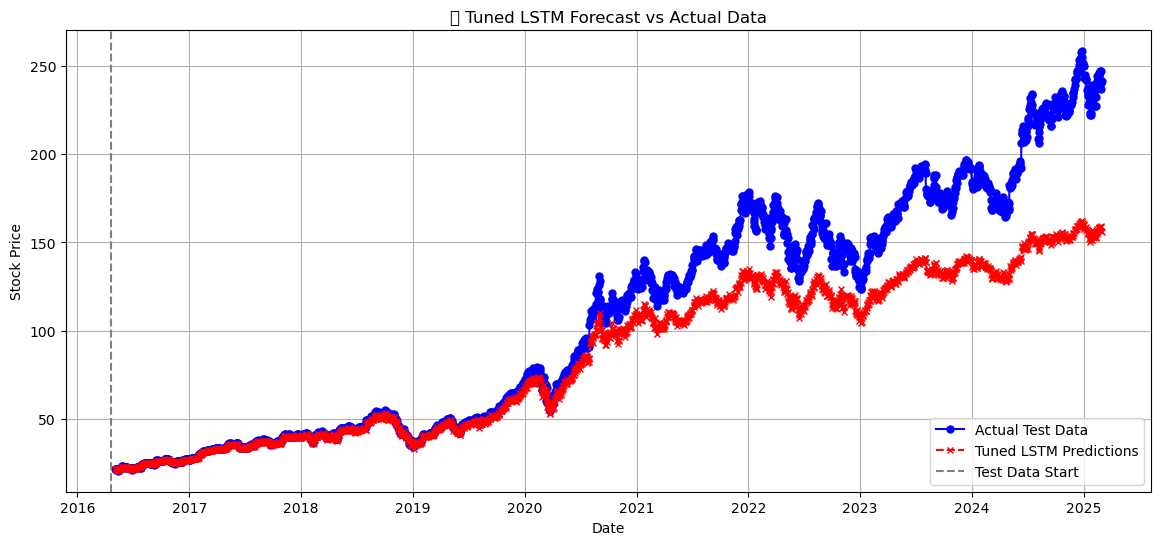

In [27]:
# Improved Visualization
plt.figure(figsize=(14, 6))
plt.plot(df.index[-len(y_test):], y_test, label="Actual Test Data", color="blue", linestyle='-', marker='o', markersize=5)
plt.plot(df.index[-len(y_pred):], y_pred, label="Tuned LSTM Predictions", color="red", linestyle='--', marker='x', markersize=5)
plt.axvline(df.index[train_size], color='gray', linestyle='--', label='Test Data Start')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("📈 Tuned LSTM Forecast vs Actual Data")
plt.legend()
plt.grid(True)
plt.show()